# Binary Classification with a Bank Churn Dataset

Your Goal: For this Episode of the Series, your task is to predict whether a customer continues with their account or closes it (e.g., churns).
## Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.
## Submission File
For each `id` in the test set, you must predict the probability for the target variable `Exited`. The file should contain a header and have the following format:

In [1]:
# id,Exited
# 165034,0.9
# 165035,0.1
# 165036,0.5
# etc.


## Install Packages

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV

In [4]:
# Import data
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')

In [5]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [6]:
train_df.head().T

,0,1,2,3,4
id,0,1,2,3,4
CustomerId,15674932,15749177,15694510,15741417,15766172
Surname,Okwudilichukwu,Okwudiliolisa,Hsueh,Kao,Chiemenam
CreditScore,668,627,678,581,716
Geography,France,France,France,France,Spain
Gender,Male,Male,Male,Male,Male
Age,33.0,33.0,40.0,34.0,33.0
Tenure,3,1,10,2,5
Balance,0.0,0.0,0.0,148882.54,0.0
NumOfProducts,2,2,2,1,2


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [8]:
train_df.columns.isna().sum()

0

In [9]:
train_df['Geography'].value_counts()

France     94215
Spain      36213
Germany    34606
Name: Geography, dtype: int64

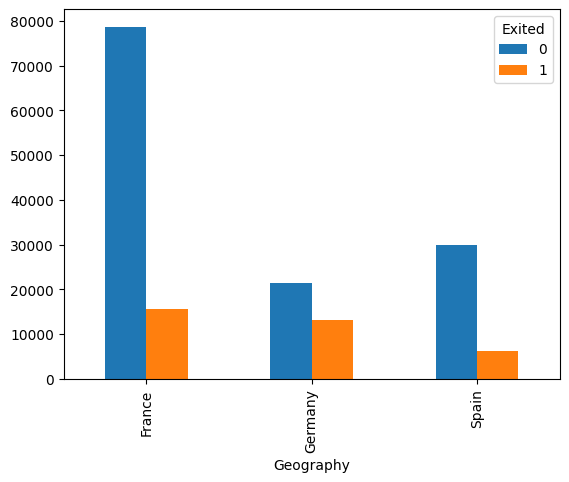

In [10]:
pd.crosstab(train_df.Geography,train_df.Exited).plot(kind='bar');

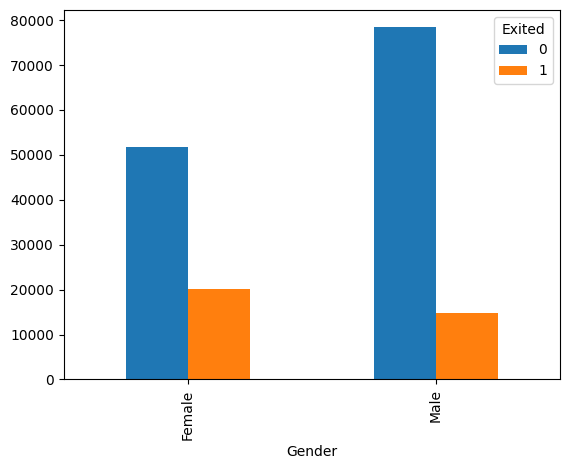

In [11]:
pd.crosstab(train_df.Gender, train_df.Exited).plot(kind='bar');

In [12]:
fig = px.scatter(train_df,
                 x= 'Balance',
                 y= 'CreditScore',
                 color = 'Exited')
fig.show();

In [13]:
fig = px.scatter(train_df,
                 x= 'CreditScore',
                 y= 'EstimatedSalary',
                 color = 'Exited')
fig.show();

Output hidden; open in https://colab.research.google.com to view.

In [14]:
fig = px.scatter(train_df,
                 x= 'EstimatedSalary',
                 y= 'Balance',
                 color = 'Exited')
fig.show();

Output hidden; open in https://colab.research.google.com to view.

In [15]:
train_df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [16]:
fig = px.violin(train_df,
                y= 'CreditScore',
                x = 'Exited',
                color = 'HasCrCard',
                box = True,
                points = 'outliers',
                hover_data = train_df.columns)
fig.show()



Output hidden; open in https://colab.research.google.com to view.

In [17]:
fig = px.violin(train_df,
                y= 'EstimatedSalary',
                x = 'Exited',
                color = 'HasCrCard',
                box = True,
                points = 'outliers',
                hover_data = train_df.columns)
fig.show()


Output hidden; open in https://colab.research.google.com to view.

In [18]:
fig = px.violin(train_df,
                y= 'CreditScore',
                x = 'Tenure',
                color = 'Exited',
                box = True,
                points = 'outliers',
                hover_data = train_df.columns)
fig.show()


Output hidden; open in https://colab.research.google.com to view.

In [19]:
fig = px.violin(train_df,
                y= 'EstimatedSalary',
                x = 'NumOfProducts',
                color = 'Exited',
                box = True,
                points = 'outliers',
                hover_data = train_df.columns)
fig.show()


Output hidden; open in https://colab.research.google.com to view.

In [20]:
fig = px.violin(train_df,
                y= 'CreditScore',
                x = 'Exited',
                color = 'IsActiveMember',
                box = True,
                points = 'outliers',
                hover_data = train_df.columns)
fig.show()


Output hidden; open in https://colab.research.google.com to view.

In [21]:
fig = px.violin(train_df,
                y= 'EstimatedSalary',
                x = 'Exited',
                color = 'IsActiveMember',
                box = True,
                points = 'outliers',
                hover_data = train_df.columns)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [22]:
fig = px.scatter(train_df,
                x= 'Age',
                y= 'EstimatedSalary',
                color= 'Exited')
fig.show();

Output hidden; open in https://colab.research.google.com to view.

In [23]:
fig = px.histogram(train_df,
                   x='Age',
                   color='Exited',
                  nbins=20)
fig.show();


After EDA i see that `Age` may play a significant roll in the model. There are no missing values to fill.

## Preperation to model
convert categorical variables into numerical. use ordinal encoder for the categories that are ordinal (none). the categories that are not ordinal either OneHotEncdoing or create a dict. of categories and use that key.
1) Data cleaning
2) OneHotEncoding

In [24]:
# Drop the identifiable variables that will not play a role in the model.
train_df = train_df.drop(['CustomerId','Surname'], axis = 1)

In [25]:
train_df.head()

,id,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [27]:
to_transform = 'Geography','Gender'

In [28]:
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(),to_transform)],remainder='passthrough')


In [28]:
x = train_df.drop('Exited',axis = 1)
y = train_df['Exited']
x = transformer.fit_transform(x)
x_train, x_test, y_train,y_test = train_test_split(x,y,test_size= .2, random_state = 9)


In [29]:
log = LogisticRegression(random_state=9)
log.fit(x_train,y_train)
log.score(x_test,y_test)

0.784166994879874

In [30]:
rf = RandomForestClassifier(class_weight= 'balanced',random_state=9, )
rf.fit(x_train,y_train)
rf.score(x_test,y_test)

0.8606356227466901

In [31]:
y_preds_log = rf.predict(x_test)
y_preds_rf = rf.predict(x_test)

In [32]:
confusion_matrix(y_preds_log, y_test)

array([[24769,  3395],
       [ 1205,  3638]])

In [33]:
print(classification_report(y_test, y_preds_log))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92     25974
           1       0.75      0.52      0.61      7033

    accuracy                           0.86     33007
   macro avg       0.82      0.74      0.76     33007
weighted avg       0.85      0.86      0.85     33007



In [34]:
confusion_matrix(y_test,y_preds_rf)

array([[24769,  1205],
       [ 3395,  3638]])

In [35]:
print(classification_report(y_test,y_preds_rf))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92     25974
           1       0.75      0.52      0.61      7033

    accuracy                           0.86     33007
   macro avg       0.82      0.74      0.76     33007
weighted avg       0.85      0.86      0.85     33007



In [36]:
# import the test data
test = pd.read_csv('/content/drive/MyDrive/test.csv')
test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [37]:
test = test.drop(['CustomerId','Surname'], axis = 1)
x_test= transformer.fit_transform(test)
test_preds_rf = rf.predict_proba(x_test)[:,1]

In [38]:
print(len(test)), print(len(test_preds_rf))

110023
110023


(None, None)

In [39]:
test_preds_rf

array([0.  , 0.44, 0.06, ..., 0.05, 0.16, 0.19])

In [40]:
# turn array into data frame
data = np.array(test_preds_rf)
test['Exited'] = data
df_results = test[['id', 'Exited']]
df_results.head()


,id,Exited
0,165034,0.00
1,165035,0.44
2,165036,0.06
3,165037,0.21
4,165038,0.32


In [41]:
df_results.to_csv('submission_bank_churn_rf1.csv', index = False)

In [42]:
# train the model on all the data

# re-import the data
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
# clean and split
train_df = train_df.drop(['CustomerId','Surname'], axis = 1)
x = train_df.drop('Exited',axis = 1)
y = train_df['Exited']
x = transformer.fit_transform(x)
# train the model
rf_full = RandomForestClassifier(class_weight = 'balanced', random_state = 9)
rf_full.fit(x,y)
# import the test data
test = pd.read_csv('/content/drive/MyDrive/test.csv')
# clean test data
test = test.drop(['CustomerId','Surname'], axis = 1)
x_test= transformer.fit_transform(test)
test_preds_rf_full = rf_full.predict_proba(x_test)[:,1]
# turn array into data frame
data = np.array(test_preds_rf_full)
test['Exited'] = data
df_results = test[['id', 'Exited']]
df_results.head()

,id,Exited
0,165034,0.02
1,165035,0.56
2,165036,0.03
3,165037,0.12
4,165038,0.29


In [43]:
df_results.to_csv('submission_bank_churn_rf_full.csv', index = False)

This models scored a .86468 AUC score.
the model can be improved through:
1. Feature engineering are ther groups maybe that are more likely or less likely to exit the bank
2. complete feature importance and remove features that are not that important
3. try hyperparameter tuning
4. try different models

In [44]:
# start with feature importance and hyperparameter tuning.
# Import data
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
# Feature importance
train_df = train_df.drop(['CustomerId','Surname'], axis = 1)
x = train_df.drop('Exited',axis = 1)
y = train_df['Exited']
x = transformer.fit_transform(x)

In [45]:
x

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 1.8144997e+05],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 4.9503500e+04],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 1.8486669e+05],
       ...,
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 1.2742956e+05],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 7.1173030e+04],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 6.1581790e+04]])

In [46]:
# %%time
# result = permutation_importance(rf_full, x,y,n_repeats=10, random_state=9,n_jobs=-1)
# forest_importances = pd.Series(result.importances_mean, index=feature_names)

In [47]:
# fig, ax = plt.subplots()
# forest_importance.plot.barr(yerr= result.importances_std, ax=ax)
# ax.set_title('Feature Importance Random Forest')
# ax.set_ylabel('Mean Accuracy Decrease')
# fig.tight_layout()
# plt.show()

## Tune the Model

In [48]:
# create list of features to try
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10,110,num = 11)]
max_depth.append(None)
min_samples_split = [2,3,5,7,10]
min_samples_leaf = [1,2,4,5]
bootstrap = [True, False]
class_weight = ['balanced']
# create grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': class_weight}

In [49]:
# # re-import the data
# train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
# # clean and split
# train_df = train_df.drop(['CustomerId','Surname'], axis = 1)
# x = train_df.drop('Exited',axis = 1)
# y = train_df['Exited']
# x = transformer.fit_transform(x)

In [50]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, random_state = 9, n_jobs = -1)
# rf_random.fit(x,y)

In [51]:
# rf_random.best_params_

In [52]:
# test = pd.read_csv('/content/drive/MyDrive/test.csv')
# # clean test data
# test = test.drop(['CustomerId','Surname'], axis = 1)
# x_test = transformer.fit_transform(test)
# test_preds_rf_full_random = rf_full_random.predict_proba(x_test)[:,1]
# # turn array into data frame
# data = np.array(test_preds_rf_full_random)
# test['Exited'] = data
# df_results = test[['id', 'Exited']]
# df_results.head()

In [53]:
# df_results.to_csv('submission_bank_churn_rf_full_random.csv', index = False)

In [54]:
# re-import the data
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
# clean and split
train_df = train_df.drop(['CustomerId','Surname'], axis = 1)
x = train_df.drop('Exited',axis = 1)
y = train_df['Exited']
x = transformer.fit_transform(x)
test = pd.read_csv('/content/drive/MyDrive/test.csv')
# clean test data
test = test.drop(['CustomerId','Surname'], axis = 1)
x_test = transformer.fit_transform(test)

In [55]:
from sklearn.neural_network import MLPClassifier

In [60]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
mlp.fit(x,y)
mlp_predictions = mlp.predict_proba((x_test)[:,1])
data = np.array(mlp_predictions)
test['Exited'] = data
df_results = test[['id', 'Exited']]
df_results.head()

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. ... 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
df_results.to_csv('submission_bank_churn_MLP.csv', index = False)

In [3]:
! pip install lightgbm

In [29]:
import lightgbm as lgb

In [31]:
# train the model on all the data

# re-import the data
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
# clean and split
train_df = train_df.drop(['CustomerId','Surname'], axis = 1)
# feature engineering
train_df["Age_Tenure"] = train_df['Age'] - train_df['Tenure']
train_df['Age_and_balance'] = train_df['Balance'] / train_df['Age']
train_df['Balance/EtimatedSalary'] = train_df['Balance'] / train_df['EstimatedSalary']
train_df['CreditScore/Age'] = train_df['CreditScore'] / train_df['Age']
train_df['Age/NumofProd'] = train_df['Age'] / train_df['NumOfProducts']
train_df['EstimatedSalary/NumofProducts'] = train_df['EstimatedSalary'] / train_df['NumOfProducts']
train_df['NumofProd/Tenure'] = train_df['NumOfProducts'] / train_df['Tenure']
train_df['CreditScore/NumofProd'] = train_df['CreditScore'] / train_df['NumOfProducts']
x = train_df.drop('Exited',axis = 1)
y = train_df['Exited']
x = transformer.fit_transform(x)
# train the model
lgb_classifier = lgb.LGBMClassifier(class_weight = 'balanced', random_state = 9)
lgb_classifier.fit(x,y)
# import the test data
test = pd.read_csv('/content/drive/MyDrive/test.csv')
# clean test data
test_df = test.drop(['CustomerId','Surname'], axis = 1)
test_df["Age_Tenure"] = test_df['Age'] - test_df['Tenure']
test_df['Age_and_balance'] = test_df['Balance'] / test_df['Age']
test_df['Balance/EtimatedSalary'] = test_df['Balance'] / test_df['EstimatedSalary']
test_df['CreditScore/Age'] = test_df['CreditScore'] / test_df['Age']
test_df['Age/NumofProd'] = test_df['Age'] / test_df['NumOfProducts']
test_df['EstimatedSalary/NumofProducts'] = test_df['EstimatedSalary'] / test_df['NumOfProducts']
test_df['NumofProd/Tenure'] = test_df['NumOfProducts'] / test_df['Tenure']
test_df['CreditScore/NumofProd'] = test_df['CreditScore'] / test_df['NumOfProducts']
x_test= transformer.fit_transform(test_df)
test_preds_lgb = lgb_classifier.predict_proba(x_test)[:,1]
# turn array into data frame
data = np.array(test_preds_lgb)
test['Exited'] = data
df_results = test[['id', 'Exited']]
df_results

[LightGBM] [Info] Number of positive: 34921, number of negative: 130113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2668
[LightGBM] [Info] Number of data points in the train set: 165034, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,id,Exited
0,165034,0.081395
1,165035,0.922917
2,165036,0.062803
3,165037,0.493508
4,165038,0.702676
...,...,...
110018,275052,0.117615
110019,275053,0.382083
110020,275054,0.048908
110021,275055,0.373680


In [32]:
df_results.to_csv('submission_bank_churn_lgb.csv', index = False)